### Prerequisite:

#### Python version <= 3.7

#### Install below python packages

In [ ]:
# !pip install contractions
# !pip install numpy
# !pip install pandas
# !pip install scikit-learn
# !pip install -U spacy
# !python -m spacy download en

#### Download raw data and unzip it.

In [2]:
# !wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip"

In [3]:
# !unzip "drugsCom_raw.zip"

#### Read the source data

In [1]:
import numpy as np
import pandas as pd

df = pd.read_table('drugsComTrain_raw.tsv')
df.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


#### Top 10 conditions.
- Get top 10 conditions based on its frequency.
- Mark all the remaining conditions to "OTHERS" category/condition.

<AxesSubplot:>

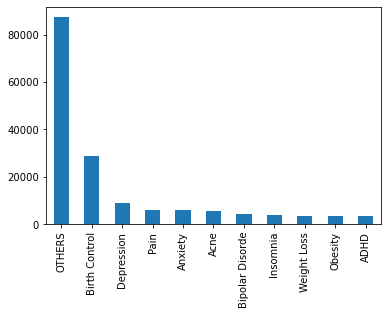

In [2]:
top_10_conditions = df['condition'].value_counts().head(10).index.tolist()
df['condition'] = df['condition'].apply(lambda x: x if x in top_10_conditions else 'OTHERS')
df['condition'].value_counts().plot(kind='bar')

Observations:
- As OTHERS condition is tagged with all the minority conditions and it rises its frequency. Will handle it later 

In [8]:
import re
import html
import contractions

def remove_chars(text):
    """
        Remove all the unneccessary special characaters.
    """
    text = html.unescape(text)
    text = contractions.fix(text)
    remove_chars_1 = r'[^A-Za-z0-9 ]'
    remove_chars_2 = r'^"'
    remove_chars_3 = r'"$'
    more_than_two_spaces = r'[\s\s]+'
    text = re.sub(remove_chars_1, ' ', text)
    text = re.sub(remove_chars_2, ' ', text)
    text = re.sub(remove_chars_3, ' ', text)
    text = re.sub(more_than_two_spaces, ' ', text)
    return text.strip()


df['cleaned_text'] = df['review'].apply(remove_chars)

In [ ]:
spacy_model("")

In [38]:
import spacy

# Load the spacy model and disable unused features
spacy_model = spacy.load('en_core_web_sm')

In [64]:
w = spacy_model("It has no side effect I take it in combination of Bystolic 5 Mg and Fish Oil")
len(w)

17

In [63]:
for token in spacy_model("It has no side effect I take it in combination of Bystolic 5 Mg and Fish Oil"):
    print(token, token.is_stop)

It True
has True
no True
side True
effect False
I True
take True
it True
in True
combination False
of True
Bystolic False
5 False
Mg False
and True
Fish False
Oil False


In [77]:
def spacy_nouns_features(text):
    """
        Generate more features using the text.
    """
    text = spacy_model(text)
    token_features = {'norm_text': [], 'norm_text_counts': 0, 'noun_words': [], 'noun_counts': 0, 'stop_word_counts': 0, 'digits_counts': 0, 'lower_counts': 0, 'upper_counts': 0, 'title_counts': 0, 'total_words': 0, 'noun_phrase_counts': 0, 'noun_phrases': []}
    for token in text:
        if token.pos_ in ['NOUN', 'PROPN']:
            token_features['noun_counts'] += 1
            token_features['noun_words'].append(str(token))
        if token.is_digit:
            token_features['digits_counts'] += 1
        if token.is_lower and len(token) > 1:
            token_features['lower_counts'] += 1
        if token.is_upper and len(token) > 1:
            token_features['upper_counts'] += 1
        if token.is_title and len(token) > 1:
            token_features['title_counts'] += 1
        if token.is_stop:
            token_features['stop_word_counts'] += 1
        else:
            token_features['norm_text'].append(str(token.lemma_))

    token_features['total_words'] = len(text)
    token_features['noun_phrase_counts'] = len(list(text.noun_chunks))
    token_features['noun_phrases'] = list(text.noun_chunks)
    token_features['norm_text_counts'] = len(token_features['norm_text'])
    token_features['norm_text'] = ' '.join(token_features['norm_text']).lower().strip()
        
    return token_features


df_spacy_vectors_nouns = df['cleaned_text'].apply(spacy_nouns_features)
# df_spacy_vectors_nouns = np.row_stack(df_spacy_vectors)
# df_spacy_vectors_nouns = pd.DataFrame(df_spacy_vectors)
# df_spacy_vectors_nouns.to_csv('df_spacy_vectors_nouns.csv', index=False) # saved
df_spacy_vectors_nouns.head()


0    {'norm_text': 'effect combination bystolic 5 m...
1    {'norm_text': 'son halfway fourth week intuniv...
2    {'norm_text': 'oral contraceptive 21 pill cycl...
3    {'norm_text': 'time form birth control glad go...
4    {'norm_text': 'suboxone completely turn life f...
Name: cleaned_text, dtype: object

In [98]:
for x in df_spacy_vectors_nouns:
    x['noun_phrases'] = [str(x) for x in x['noun_phrases']]
    x['norm_text'] = ' '.join([str(x) for x in x['norm_text'].split()])

In [100]:
df_spacy_vectors_nouns_pkl_obj = [x for x in df_spacy_vectors_nouns]
len(df_spacy_vectors_nouns_pkl_obj)

161297

In [101]:
# import pickle

# file_to_store = open("df_spacy_vectors_nouns.pkl", "wb")
# pickle.dump(df_spacy_vectors_nouns_pkl_obj, file_to_store)
# file_to_store.close()

In [102]:
# len(set([y for x in df_spacy_vectors_nouns for y in x[8]]))

In [11]:
def spacy_features(text):
    """
        Generate more features using the text.
    """
    text = spacy_model(text)
    token_features = {'norm_text': '', 'noun_counts': 0, 'digits_counts': 0, 'lower_counts': 0, 'upper_counts': 0, 'title_counts': 0, 'total_words': 0}
    for token in text:
        if token.pos_ in ['NOUN', 'PROPN']:
            token_features['noun_counts'] += 1
        if token.is_digit:
            token_features['digits_counts'] += 1
        if token.is_lower:
            token_features['lower_counts'] += 1
        if token.is_upper:
            token_features['upper_counts'] += 1
        if token.is_title:
            token_features['title_counts'] += 1
        token_features['total_words'] = len(text)
        token_features['norm_text'] += token.lemma_ + ' '
    token_features['norm_text'] = token_features['norm_text'].lower().strip()
        
    return list(token_features.values())


df_spacy_vectors = df['cleaned_text'].apply(spacy_features)
df_spacy_vectors = np.row_stack(df_spacy_vectors)
df_spacy_vectors = pd.DataFrame(df_spacy_vectors)
df_spacy_vectors.to_csv('spacy_features.csv', index=False) # saved
df_spacy_vectors.head()

,0,1,2,3,4,5,6
0,it have no side effect i take it in combinatio...,5,1,10,1,6,17
1,my son be halfway through his fourth week of i...,24,1,126,2,13,141
2,i use to take another oral contraceptive which...,35,2,118,6,15,136
3,this be my first time use any form of birth co...,20,5,77,5,10,92
4,suboxone have completely turn my life around i...,27,0,112,9,17,129


In [112]:
df_spacy_vectors_nouns[0]

{'norm_text': 'effect combination bystolic 5 mg fish oil',
 'norm_text_counts': 7,
 'noun_words': ['effect', 'combination', 'Mg', 'Fish', 'Oil'],
 'noun_counts': 5,
 'stop_word_counts': 10,
 'digits_counts': 1,
 'lower_counts': 10,
 'upper_counts': 0,
 'title_counts': 5,
 'total_words': 17,
 'noun_phrase_counts': 6,
 'noun_phrases': ['It',
  'no side effect',
  'I',
  'it',
  'combination',
  'Bystolic 5 Mg and Fish Oil']}

In [3]:
import pickle
import pandas as pd

In [4]:
file_to_store = open("df_spacy_vectors_nouns.pkl", "rb")
df_spacy_vectors_nouns_pkl_obj = pickle.load(file_to_store)
file_to_store.close()

In [5]:
list_of_fs = []
for x in df_spacy_vectors_nouns_pkl_obj:
    f = {}
    f['norm_text'] = x['norm_text']
    f['norm_text_counts'] = x['norm_text_counts']
    f['noun_counts'] = x['noun_counts']
    f['stop_word_counts'] = x['stop_word_counts']
    f['digits_counts'] = x['digits_counts']
    f['total_words'] = x['total_words']
    f['noun_phrase_counts'] = x['noun_phrase_counts']
    list_of_fs.append(f)
len(list_of_fs)

161297

In [6]:
df_f = pd.DataFrame(list_of_fs)
df_f.head(2)

,norm_text,norm_text_counts,noun_counts,stop_word_counts,digits_counts,total_words,noun_phrase_counts
0,effect combination bystolic 5 mg fish oil,7,5,10,1,17,6
1,son halfway fourth week intuniv concerned begi...,53,24,88,1,141,34


In [7]:
df_f.shape, df.shape

((161297, 7), (161297, 7))

In [8]:
df_f['condition'] = df['condition']

In [9]:
# Category-wise length review

df_f['sentence_length'] = df_f["norm_text"].apply(lambda x: len(x.split()))

In [10]:
df_f['condition'].unique()

array(['OTHERS', 'ADHD', 'Birth Control', 'Bipolar Disorde', 'Depression',
       'Obesity', 'Insomnia', 'Pain', 'Anxiety', 'Acne', 'Weight Loss'],
      dtype=object)

In [11]:
# df['length_bins'] = pd.cut(df['sentence_length'], bins=40)
cut_bins = [0, 1, 2, 5, 10, 20, 30, 50, 70, 100, 200, 300, 400, 500, 600, 700, 800, 900]
df_f['length_bins'] = pd.cut(df_f['sentence_length'], bins=cut_bins)

OTHERS


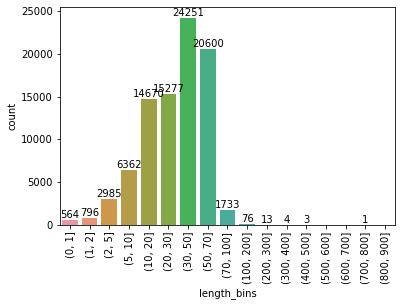

ADHD


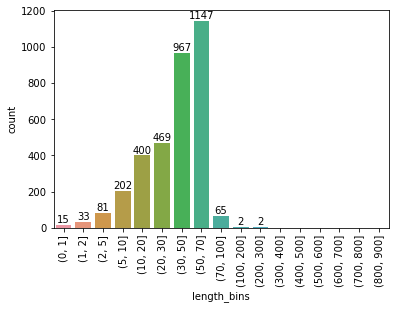

Birth Control


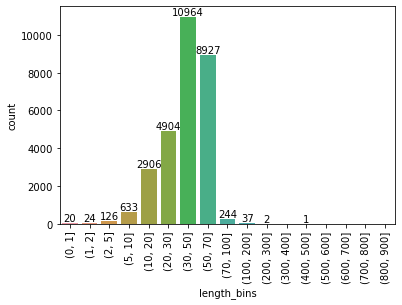

Bipolar Disorde


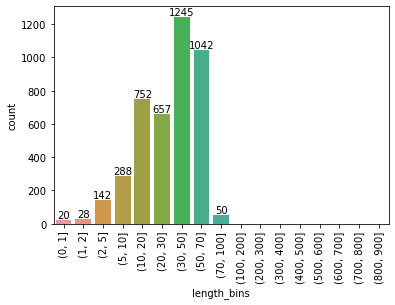

Depression


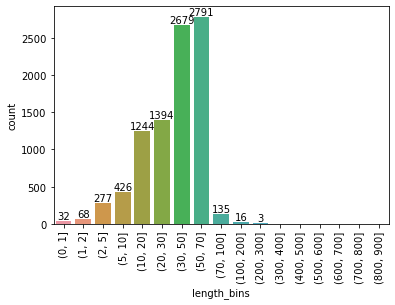

Obesity


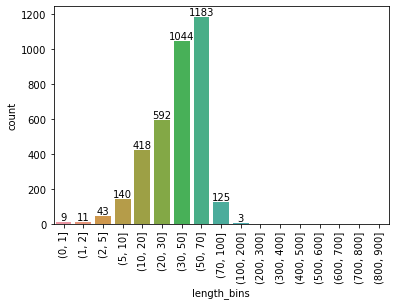

Insomnia


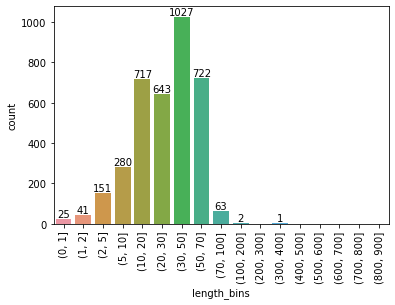

Pain


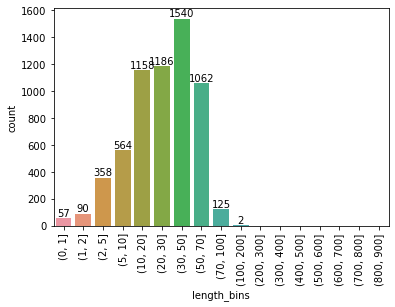

Anxiety


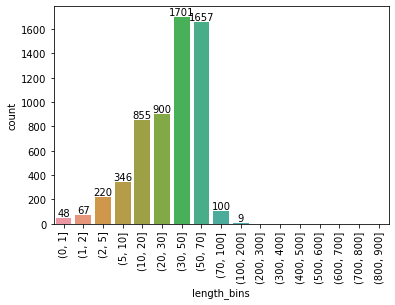

Acne


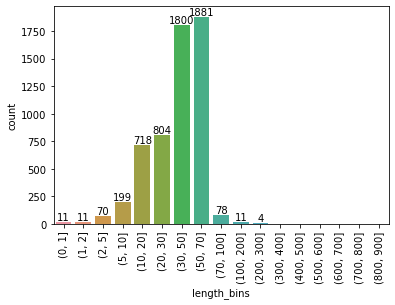

Weight Loss


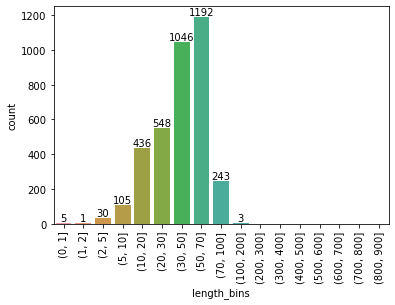

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

for condition in df_f['condition'].unique():
    print(condition)
    p = sns.countplot(x ='length_bins', data = df_f[df_f['condition'] == condition])
    p.set_xticklabels(p.get_xticklabels(), rotation=90) 
    p.bar_label(p.containers[0], label_type='edge')
    plt.show()


In [13]:
other_downsampled_indexes1 = df_f[(df_f['condition'] == 'OTHERS') & ((df_f['sentence_length'] >= 30) & (df_f['sentence_length'] < 50 ))].sample(frac=1)[7000:].index.tolist()
len(other_downsampled_indexes1)

17502

In [14]:
other_downsampled_indexes2 = df_f[(df_f['condition'] == 'OTHERS') & ((df_f['sentence_length'] >= 50) & (df_f['sentence_length'] < 70 ))].sample(frac=1)[7000:].index.tolist()
len(other_downsampled_indexes2)

14416

In [15]:
other_downsampled_indexes3 = df_f[(df_f['condition'] == 'OTHERS')].sample(frac=1)[40000:].index.tolist()
len(other_downsampled_indexes3)

47346

In [16]:
df_f[(df_f['condition'] == 'OTHERS')].shape

(87346, 10)

In [17]:
other_downsampled_indexes = list(set(other_downsampled_indexes1 + other_downsampled_indexes2 + other_downsampled_indexes3))
len(other_downsampled_indexes)

61903

In [18]:
df_f.drop(df_f.index[other_downsampled_indexes], inplace=True) # Drop indexes

In [19]:
df_f.shape

(99394, 10)

<AxesSubplot:>

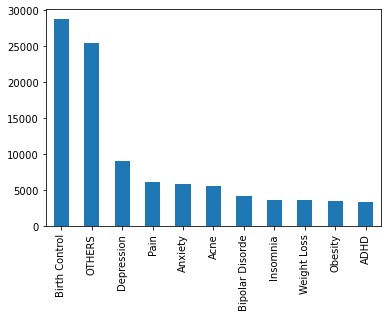

In [20]:
df_f['condition'].value_counts().plot(kind='bar')

In [21]:
# Drop 2 tokens sentences and greater than 200

df_f = df_f[~((df_f['sentence_length'] <= 2) | (df_f['sentence_length'] > 100))]
df_f.shape

(97982, 10)

<AxesSubplot:xlabel='condition', ylabel='count'>

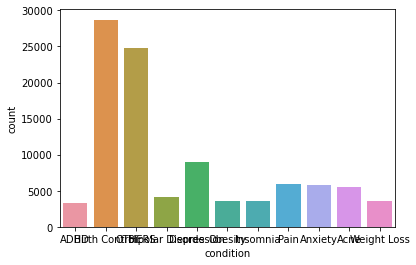

In [22]:
sns.countplot(x='condition', data=df_f)

In [23]:
df_f.head(2)

,norm_text,norm_text_counts,noun_counts,stop_word_counts,digits_counts,total_words,noun_phrase_counts,condition,sentence_length,length_bins
1,son halfway fourth week intuniv concerned begi...,53,24,88,1,141,34,ADHD,53,"(50, 70]"
2,oral contraceptive 21 pill cycle happy light p...,55,35,81,2,136,37,Birth Control,55,"(50, 70]"


In [24]:
# !pip install imbalanced-learn

In [25]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
y = le.fit_transform(df_f['condition'])
y

array([0, 4, 4, ..., 4, 7, 7])

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=0.5)
X = vectorizer.fit_transform(df_f['norm_text'])
print(X.shape)

(97982, 796749)


In [182]:
from sklearn.feature_extraction.text import HashingVectorizer

vectorizer = HashingVectorizer(ngram_range=(1, 3), n_features=2 ** 20)
X = vectorizer.fit_transform(df_f['norm_text'])
print(X.shape)

(159105, 1048576)


In [183]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df_f[['norm_text_counts', 'noun_counts', 'stop_word_counts',  'digits_counts', 'total_words', 'noun_phrase_counts']])
X_scaled.shape

(159105, 6)

In [173]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=25, stratify=y)
# X_train_actual, X_test_actual, y_train_actual, y_test_actual = train_test_split(X, y, test_size=0.33, random_state=25, stratify=y)

In [174]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)
X_train.shape, y_train.shape

((211541, 796749), (211541,))

In [230]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

X_train1 = X_train[np.where(y_binary_test_pred == 1)[0]]
y_train1 = y_train[np.where(y_binary_test_pred == 1)[0]]
X_test1 = X_test[np.where(y_binary_test_pred == 1)[0]]
y_test1 = y_test[np.where(y_binary_test_pred == 1)[0]]



l_svc_clf = LinearSVC(random_state=25, class_weight='balanced', verbose=1)
clf = CalibratedClassifierCV(base_estimator=l_svc_clf, cv=3)

clf.fit(X_train1, y_train1)

y_train_pred1 = clf.predict(X_train1)
y_test_pred1 = clf.predict(X_test1)

print('Training accuracy: ', accuracy_score(y_train1, y_train_pred1))
print('Test accuracy: ', accuracy_score(y_test1, y_test_pred1))

print(classification_report(y_test1, y_test_pred1))

[LibLinear].......*
optimization finished, #iter = 73
Objective value = -441.815729
nSV = 5667
....*
optimization finished, #iter = 49
Objective value = -479.339421
nSV = 4790
....*.
optimization finished, #iter = 50
Objective value = -867.636380
nSV = 6299
......*
optimization finished, #iter = 62
Objective value = -682.137265
nSV = 6867
...*
optimization finished, #iter = 34
Objective value = -889.985925
nSV = 8411
...*.
optimization finished, #iter = 40
Objective value = -1222.246729
nSV = 8020
......*
optimization finished, #iter = 69
Objective value = -473.085814
nSV = 3942
...*
optimization finished, #iter = 36
Objective value = -2068.845333
nSV = 12283
.......*
optimization finished, #iter = 71
Objective value = -645.588272
nSV = 4830
....*
optimization finished, #iter = 47
Objective value = -770.608768
nSV = 5718
.......*
optimization finished, #iter = 71
Objective value = -616.234731
nSV = 4518
[LibLinear].......*
optimization finished, #iter = 71
Objective value = -430.798059

In [150]:
print(classification_report(y_test, y_pred_by_threshold))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      1099
           1       0.95      0.91      0.93      1832
           2       0.80      0.75      0.78      1907
           3       0.87      0.75      0.80      1378
           4       0.93      0.98      0.96      9473
           5       0.83      0.79      0.81      2952
           6       0.89      0.80      0.84      1189
           7       0.75      0.86      0.80      8169
           8       0.82      0.68      0.75      1170
           9       0.90      0.65      0.76      1978
          10       0.82      0.68      0.75      1188

    accuracy                           0.85     32335
   macro avg       0.86      0.80      0.83     32335
weighted avg       0.86      0.85      0.85     32335



In [36]:
clf.predict(X_test[0:2])

array([9, 9])

In [37]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [38]:
from sklearn.metrics import confusion_matrix

In [39]:
# le.inverse_transform(y_test_pred)

Confusion matrix, without normalization


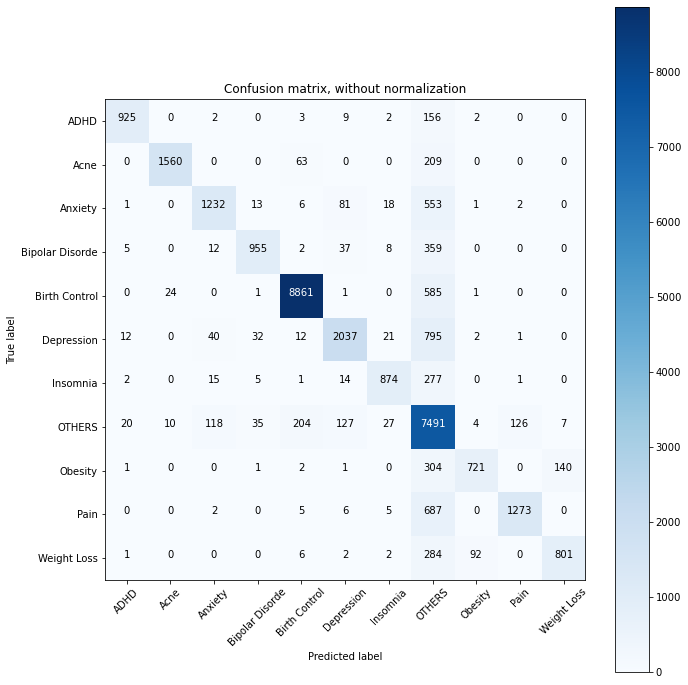

In [147]:
cnf_matrix = confusion_matrix(le.inverse_transform(y_test), le.inverse_transform(y_pred_by_threshold), labels=le.classes_)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=le.classes_, title='Confusion matrix, without normalization')

In [176]:
from copy import deepcopy

In [182]:
y_binary_test = deepcopy(y_test)
y_binary_train = deepcopy(y_train)

In [183]:
y_binary_test[y_binary_test != 7] = 1
y_binary_test[y_binary_test == 7] = 0

y_binary_train[y_binary_train != 7] = 1
y_binary_train[y_binary_train == 7] = 0

In [184]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


l_svc_clf = LinearSVC(random_state=25, class_weight='balanced', verbose=1)
clf = CalibratedClassifierCV(base_estimator=l_svc_clf, cv=3)

clf.fit(X_train, y_binary_train)

y_binary_train_pred = clf.predict(X_train)
y_binary_test_pred = clf.predict(X_test)

print('Training accuracy: ', accuracy_score(y_binary_train, y_binary_train_pred))
print('Test accuracy: ', accuracy_score(y_binary_test, y_binary_test_pred))

print(classification_report(y_binary_test, y_binary_test_pred))

[LibLinear]..................*.*
optimization finished, #iter = 191
Objective value = -7949.507343
nSV = 61231
[LibLinear]...................*
optimization finished, #iter = 191
Objective value = -9467.246804
nSV = 66386
[LibLinear]..................*
optimization finished, #iter = 183
Objective value = -10026.718544
nSV = 69158
Training accuracy:  0.9940011628951362
Test accuracy:  0.9050255141487552
              precision    recall  f1-score   support

           0       0.89      0.71      0.79      8169
           1       0.91      0.97      0.94     24166

    accuracy                           0.91     32335
   macro avg       0.90      0.84      0.87     32335
weighted avg       0.90      0.91      0.90     32335



In [185]:
confusion_matrix(y_binary_test, y_binary_test_pred)

array([[ 5832,  2337],
       [  734, 23432]])

In [218]:
len(y_test)

32335

In [228]:
y_test_non_other = y_test[np.where(y_binary_test_pred == 1)[0]]
y_test_non_other_pred = y_test_pred[np.where(y_binary_test_pred == 1)[0]]

In [229]:
print('Test accuracy: ', accuracy_score(y_test_non_other, y_test_non_other_pred))

print(classification_report(y_test_non_other, y_test_non_other_pred))

Test accuracy:  0.8469866894330397
              precision    recall  f1-score   support

           0       0.93      0.89      0.91      1083
           1       0.97      0.90      0.93      1803
           2       0.83      0.74      0.78      1842
           3       0.89      0.79      0.83      1295
           4       0.95      0.99      0.97      9369
           5       0.84      0.80      0.82      2839
           6       0.88      0.81      0.85      1139
           7       0.43      0.59      0.50      2337
           8       0.84      0.69      0.76      1154
           9       0.88      0.80      0.84      1756
          10       0.80      0.75      0.78      1152

    accuracy                           0.85     25769
   macro avg       0.84      0.79      0.81     25769
weighted avg       0.86      0.85      0.85     25769



In [195]:
y_binary_test_pred.shape

(32335,)

In [199]:
y_binary_test_binarize = label_binarize(y_binary_test, classes=list(set(y_binary_test)))
y_binary_binarize_test_pred = clf.predict_proba(X_test)


fpr, tpr, thresholds = roc_curve(y_binary_test, y_binary_binarize_test_pred)

ValueError: y should be a 1d array, got an array of shape (32335, 2) instead.

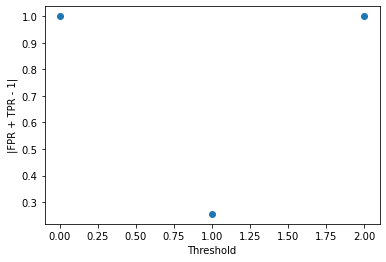

In [192]:
plt.scatter(thresholds,np.abs(fpr+tpr-1))
plt.xlabel("Threshold")
plt.ylabel("|FPR + TPR - 1|")
plt.show()

In [71]:
clf.predict_proba(X_test[:1]) > 0.9

array([[False, False, False, False, False, False, False, False, False,
        False, False]])

In [53]:
y_test_predict_probabilities = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_test_predict_probabilities)

ValueError: multiclass format is not supported

In [152]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from numpy import argmax

y_test_predict_probabilities = clf.predict_proba(X_test)

roc_auc_score(y_test, y_test_predict_probabilities, multi_class = 'ovr')

# # calculate roc curves
# for class_ in list(set(y_test)):
#     print(class_, le.classes_[class_])
# #     fpr, tpr, thresholds = roc_curve(y_test, y_test_pred, pos_label = class_)
    
#     fpr, tpr, _ = roc_curve(y_test, y_test_predict_probabilities, pos_label = class_)
#     # get the best threshold
#     J = tpr - fpr
#     ix = argmax(J)
#     best_thresh = thresholds[ix]
#     print('Best Threshold=%f' % (best_thresh))

0.9821499100195621

ADHD 0


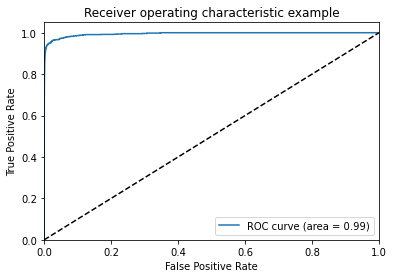

Acne 1


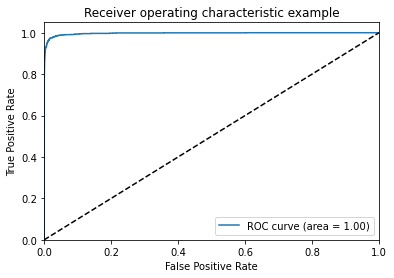

Anxiety 2


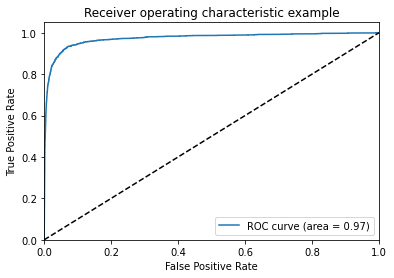

Bipolar Disorde 3


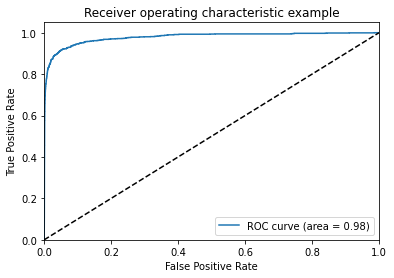

Birth Control 4


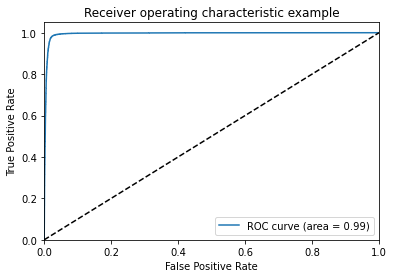

Depression 5


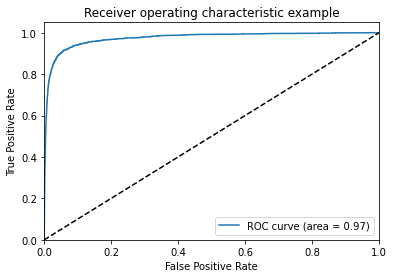

Insomnia 6


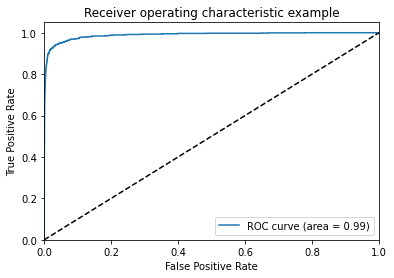

OTHERS 7


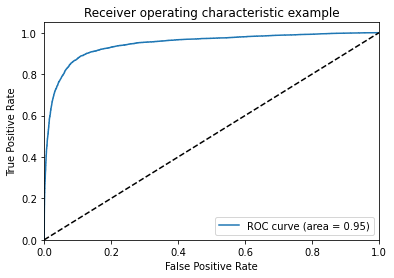

Obesity 8


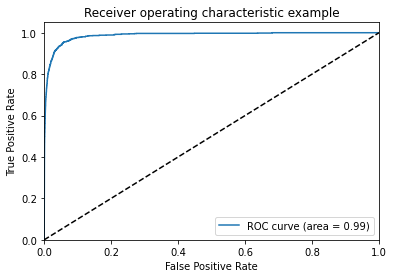

Pain 9


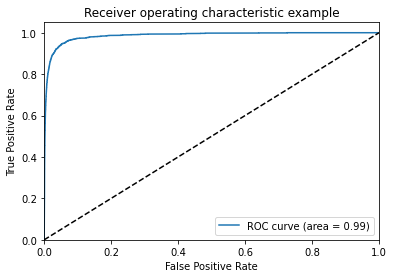

Weight Loss 10


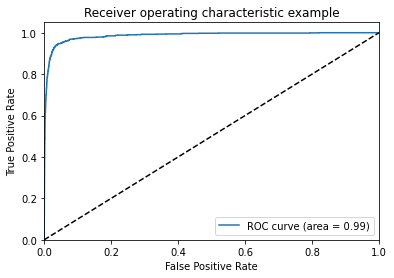

In [86]:
# Compute ROC curve and ROC area for each class
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_test_binarize = label_binarize(y_test, classes=list(set(y_test)))


fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(11):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarize[:, i], y_test_predict_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(11):
    print(le.classes_[i], i)
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    


In [59]:
y_test_predict_probabilities[:, i]

array([5.59e-05, 2.08e-04, 3.20e-04, ..., 7.64e-05, 2.74e-05, 2.53e-04])

In [85]:
y_test[90]

7

In [65]:
from sklearn.preprocessing import label_binarize

label_binarize(y_test, classes=list(set(y_test)))[0]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [83]:
argmax(y_test_predict_probabilities[90]), y_test_predict_probabilities[90]

(7,
 array([7.81e-04, 1.19e-03, 9.05e-04, 3.46e-04, 3.28e-04, 8.08e-04,
        4.09e-05, 9.95e-01, 5.37e-05, 6.00e-05, 1.30e-06]))

In [161]:
for i in range(len(y_test)):
    print(y_test_predict_probabilities[i], argmax(y_test_predict_probabilities[i]))
    break

[5.59e-05 1.97e-05 7.48e-05 3.29e-06 1.38e-02 3.33e-05 1.96e-07 4.53e-01
 4.51e-06 5.33e-01 7.90e-06] 9


In [163]:
5.33e-01, y_test[0]

(0.533, 9)

In [149]:
y_pred_by_threshold = []

for i in range(len(y_test)):
    a = argmax(y_test_predict_probabilities[i] > 0.3) if np.any((y_test_predict_probabilities[i] >= 0.3) == True) else 7
    y_pred_by_threshold.append(a)
    

In [141]:
y_test[:10], y_pred_by_threshold[:10]

(array([ 9,  9,  7,  4,  5,  7,  7, 10,  3,  7]),
 [7, 9, 7, 4, 7, 7, 7, 7, 7, 7])

In [134]:
np.any((y_test_predict_probabilities[0] >= 0.97) == True)

False

In [125]:
argmax(y_test_predict_probabilities[0] >= 0.97)

0

In [136]:
argmax(y_test_predict_probabilities[1] > 0.97) if np.any((y_test_predict_probabilities[1] >= 0.97) == True) else 7

9

In [106]:
y_test_predict_probabilities[13].any() >= 0.97

True

In [29]:
# !pip install lightgbm
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 1.3 MB 1.3 MB/s eta 0:00:01


In [42]:
import lightgbm as lgb 

In [43]:
train_data = lgb.Dataset(X_train,label=y_train)
train_data

In [44]:
param = {'num_leaves':150, 'objective':'multiclass', 'num_class': 11, 'max_depth':7, 'learning_rate':.05, 'max_bin':200}
param['metric'] = ['multi_logloss']


In [ ]:
num_round = 1
lgbm = lgb.train(param, train_data, num_round)


In [ ]:
ypred2=lgbm.predict(x_test)

In [172]:
y_test

array([1, 1, 0, ..., 0, 0, 0])

In [167]:
y_test_binary = y_test

In [170]:
y_test_binary[y_test_binary != 7] = 1
y_test_binary[y_test_binary == 7] = 0

In [171]:
y_test_binary

array([1, 1, 0, ..., 0, 0, 0])

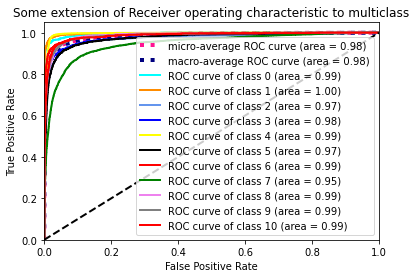

In [158]:
# First aggregate all false positive rates

n_classes = 11

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarize[:, i], y_test_predict_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarize.ravel(), y_test_predict_probabilities.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

from itertools import cycle
colors = cycle(["aqua", "darkorange", "cornflowerblue", "blue", "yellow", "black", "red", "green", "violet", "grey", "red"])
lw = 2
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

In [30]:
import xgboost as xgb 

/Users/kkvp639/.local/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [ ]:
dtrain=xgb.DMatrix(X_train,label=y_train)
dtest=xgb.DMatrix(X_test)

In [150]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33, random_state=25, stratify=y)

In [151]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


clf = RandomForestClassifier(random_state=25, class_weight='balanced', verbose=1)
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

print('Training accuracy: ', accuracy_score(y_train, y_train_pred))
print('Test accuracy: ', accuracy_score(y_test, y_test_pred))

print(classification_report(y_test, y_test_pred))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   10.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Training accuracy:  0.935799681681904
Test accuracy:  0.6703676567284751
              precision    recall  f1-score   support

           0       0.60      0.38      0.46      1844
           1       0.49      0.32      0.39      1948
           2       0.48      0.41      0.44      1394
           3       0.66      0.58      0.62      9500
           4       0.62      0.40      0.49      2993
           5       0.42      0.30      0.35      1212
           6       0.71      0.84      0.77     29941
           7       0.64      0.39      0.48      1178
           8       0.42      0.36      0.39      2028
           9       0.65      0.37      0.48      1191

    accuracy                           0.67     53229
   macro avg       0.57      0.44      0.49     53229
weighted avg       0.66      0.67      0.66     53229



[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.6s finished


In [15]:
from sklearn.feature_extraction.text import HashingVectorizer

vectorizer = HashingVectorizer(ngram_range=(1, 3), n_features=2 ** 20)
X = vectorizer.fit_transform(df_spacy_vectors[0])
print(X.shape)

(161297, 1048576)


In [14]:
print(X.shape)

NameError: name 'X' is not defined

In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df_spacy_vectors.loc[:, 1:])
X_scaled.shape

(161297, 6)

In [18]:
1048576 + 6

1048582

In [17]:
from scipy import sparse
sparse_X_scaled = sparse.csr_matrix(X_scaled)
sparse_X_scaled

<161297x6 sparse matrix of type '<class 'numpy.float64'>'
	with 905274 stored elements in Compressed Sparse Row format>

In [21]:
from scipy.sparse import hstack

X1 = hstack((X, sparse_X_scaled))
X1

<161297x1048582 sparse matrix of type '<class 'numpy.float64'>'
	with 33750573 stored elements in COOrdinate format>

In [23]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
y = le.fit_transform(df['condition'])
y

array([6, 6, 3, ..., 6, 6, 6])

In [35]:
from mlxtend.classifier import StackingClassifier
from mlxtend.feature_selection import ColumnSelector
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

pipe1 = make_pipeline(ColumnSelector(cols=tuple(range(0, 1048576))),
                      LinearSVC(class_weight='balanced', random_state=25, verbose=1))
pipe2 = make_pipeline(ColumnSelector(cols=tuple(range(1048576, 1048582))),
                      LogisticRegression(class_weight='balanced', random_state=25, n_jobs=-1, verbose=1))

sclf = StackingClassifier(classifiers=[pipe1, pipe2], 
                          meta_classifier=LinearSVC(class_weight='balanced', random_state=25, verbose=1),
                         verbose=2)

sclf.fit(X1.tocsr(), y)

Fitting 2 classifiers...
Fitting classifier1: pipeline (1/2)
Pipeline(steps=[('columnselector',
                 ColumnSelector(cols=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                      13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                      23, 24, 25, 26, 27, 28, 29, ...))),
                ('linearsvc',
                 LinearSVC(class_weight='balanced', random_state=25,
                           verbose=1))])
[LibLinear]...........*
optimization finished, #iter = 115
Objective value = -3437.930035
nSV = 18283
..........*.
optimization finished, #iter = 110
Objective value = -9407.283496
nSV = 36079
...............*
optimization finished, #iter = 151
Objective value = -5975.290573
nSV = 30974
....*
optimization finished, #iter = 44
Objective value = -8579.611106
nSV = 41859
.......*
optimization finished, #iter = 77
Objective value = -12320.134700
nSV = 45761
...............*.*
optimization finished, #iter = 162
Objective value = -4

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           70     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.71400D+05    |proj g|=  7.05874D+02


 This problem is unconstrained.



At iterate   50    f=  3.53954D+05    |proj g|=  3.71408D+02

At iterate  100    f=  3.53517D+05    |proj g|=  8.33490D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   70    100    106      1     0     0   8.335D+01   3.535D+05
  F =   353517.03586991294     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.8s finished


[LibLinear]....................................................................................................
optimization finished, #iter = 1000

Using -s 2 may be faster (also see FAQ)

Objective value = -2275.502404
nSV = 12364
....................................................................................................
optimization finished, #iter = 1000

Using -s 2 may be faster (also see FAQ)

Objective value = -31185.079298
nSV = 47356
....................................................................................................
optimization finished, #iter = 1000

Using -s 2 may be faster (also see FAQ)

Objective value = -46187.108368
nSV = 62691
....................................................................................................
optimization finished, #iter = 1000

Using -s 2 may be faster (also see FAQ)

Objective value = -49074.060876
nSV = 147697
.

/Users/kkvp639/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


...................................................................................................
optimization finished, #iter = 1000

Using -s 2 may be faster (also see FAQ)

Objective value = -57047.807247
nSV = 161290
....................................................................................................
optimization finished, #iter = 1000

Using -s 2 may be faster (also see FAQ)

Objective value = -56283.121931
nSV = 161291
....................................................................................................
optimization finished, #iter = 1000

Using -s 2 may be faster (also see FAQ)

Objective value = -45691.960862
nSV = 149818
....................................................................................................
optimization finished, #iter = 1000

Using -s 2 may be faster (also see FAQ)

Objective value = -44990.304656
nSV = 100141
....................................................................................................
opti

/Users/kkvp639/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


StackingClassifier(classifiers=[Pipeline(steps=[('columnselector',
                                                 ColumnSelector(cols=(0, 1, 2,
                                                                      3, 4, 5,
                                                                      6, 7, 8,
                                                                      9, 10, 11,
                                                                      12, 13,
                                                                      14, 15,
                                                                      16, 17,
                                                                      18, 19,
                                                                      20, 21,
                                                                      22, 23,
                                                                      24, 25,
                                                                     

In [36]:
from sklearn.metrics import accuracy_score

y_pred = sclf.predict(X1.tocsr())

accuracy_score(y, y_pred)

0.8090541051600464

/Users/kkvp639/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
